In [1]:
#packages import
import os
os.chdir('..') #cd to PiperNET folder

from pathlib import Path
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from src.rnaseq_utils import *

#matplotlib settings
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

#config file path
config_path = Path('config/rnaseq_dataprep.yaml')

In [2]:
### Data import ###

#proteomes
proteome_list = get_config(config_path, data='proteome_csv')

for sample, path in proteome_list.items(): 
    proteome_list[sample] = pd.read_csv(path, index_col='id') #update proteome_list with dfs

#unique df with all proteomes
proteomes_all = pd.DataFrame()
for sample, proteome in proteome_list.items(): #iterate over each proteome in proteome_list
    proteome['sample'] = sample #add 'sample' column with sample name (e.g., piper09)
    proteome.columns = [col.split('_', 1)[1] if 'rep' in col else col for col in proteome.columns] #remove sample name from tpm cols
    proteomes_all = pd.concat([proteomes_all, proteome]) #concat df


#sonicparanoid
sonicpd_path = get_config(config_path, data='various', file='sonicparanoid')
sonicpd = import_sonicpd(sonicpd_path)

#blastDB paths
blastDB_paths = get_config(config_path, data='blastDB')

#sequences paths
seq_paths = get_config(config_path, data='enzymeDB')

#prefixes
prefixes = get_config(config_path, data='prefix', filepaths=False)

#species_names
species_names = get_config(config_path, data='species', filepaths=False)

#colors legeng
legend = get_config(config_path, data='colors', filepaths=False)

### Count PKS candidates based on Pfam domains ('PF00195' or 'PF02797)

Total N° of candidates: 158


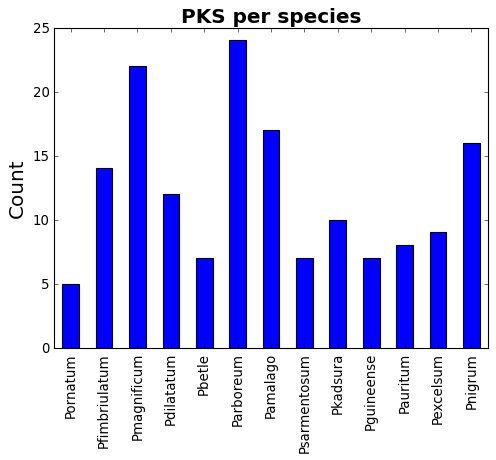

In [3]:
#keep sequences with PF00195 or PF02797
pks = proteomes_all[proteomes_all['pfam'].str.contains('PF00195|PF02797', na=False)] #keep 'PF00195' or 'PF02797
pks_count = pks.groupby('sample').size() #count pks per sample
pks_count.rename(index=species_names, inplace=True) #rename using species_names
print(f'Total N° of candidates: {pks_count.sum()}')

#bar plot
plt.figure(figsize=(7,5))
pks_count.plot(kind='bar')
plt.title('PKS per species', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.xlabel('')
plt.ylabel('Count', fontdict={'fontsize': 18})
plt.show()

### ORF type and seqeunce lenght distribution of PKS candidates

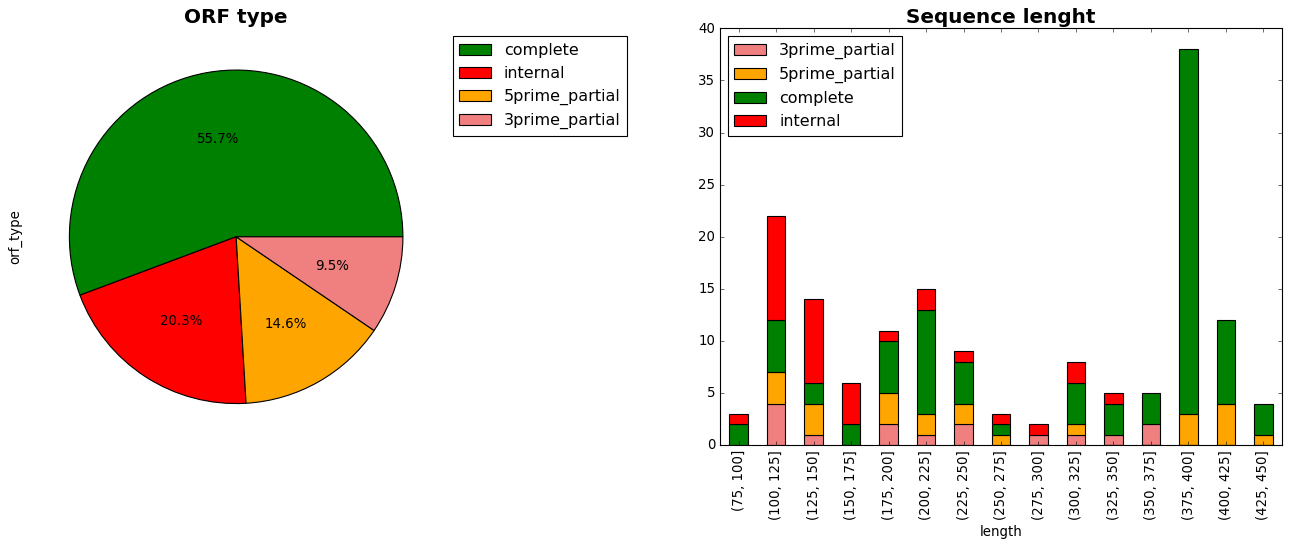

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

#orf_type distribution
pks_orftype = pks['orf_type'].value_counts() #count orf_type

#map colors to orf_type
colormap = {'complete': 'green', '3prime_partial': 'lightcoral', '5prime_partial': 'orange', 'internal': 'red'}
colors = pks_orftype.index.map(lambda x: colormap[x])

#pie chart
pks_orftype.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False, labels=None, ax=axs[0])
axs[0].set_title('ORF type', fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[0].legend(pks_orftype.index, bbox_to_anchor=(1, 1), loc='upper left') #legend

#sequence length distribution
bins = pd.cut(pks['length'], bins=range(0, pks['length'].max(), 25)) #bin pks['length']
count = pks.groupby([bins, 'orf_type']).size().unstack() #count occurrence of orf_types in each bin
count = count[count.sum(axis=1) > 0] #drop all-zeros rows

#stacked bar plot
colors = count.columns.map(lambda x: colormap[x])
count.plot(kind='bar', stacked=True, color=colors, ax=axs[1])
axs[1].set_title('Sequence lenght', fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[1].legend(title=None, loc='upper left')  # remove legend title

#plot settings
plt.tight_layout()
plt.show()

### PKS candidates in orthogroups
Orthogroups in `sonicpd` containting any of the PKS sequences (`pks.index`) are retrieved. Two heatmaps are built:
- Count-based: n° of genes per species in each orthogroup (`pks_orths_count`). This highlights the species involved in each orthogroup.
- Expression-based: max or mean expression of genes per species in each orthogroup (`pks_orths_expr`). This highlights expression levels of genes in each orthogroup.

Total N° of PKS candidates in orthologs: 103


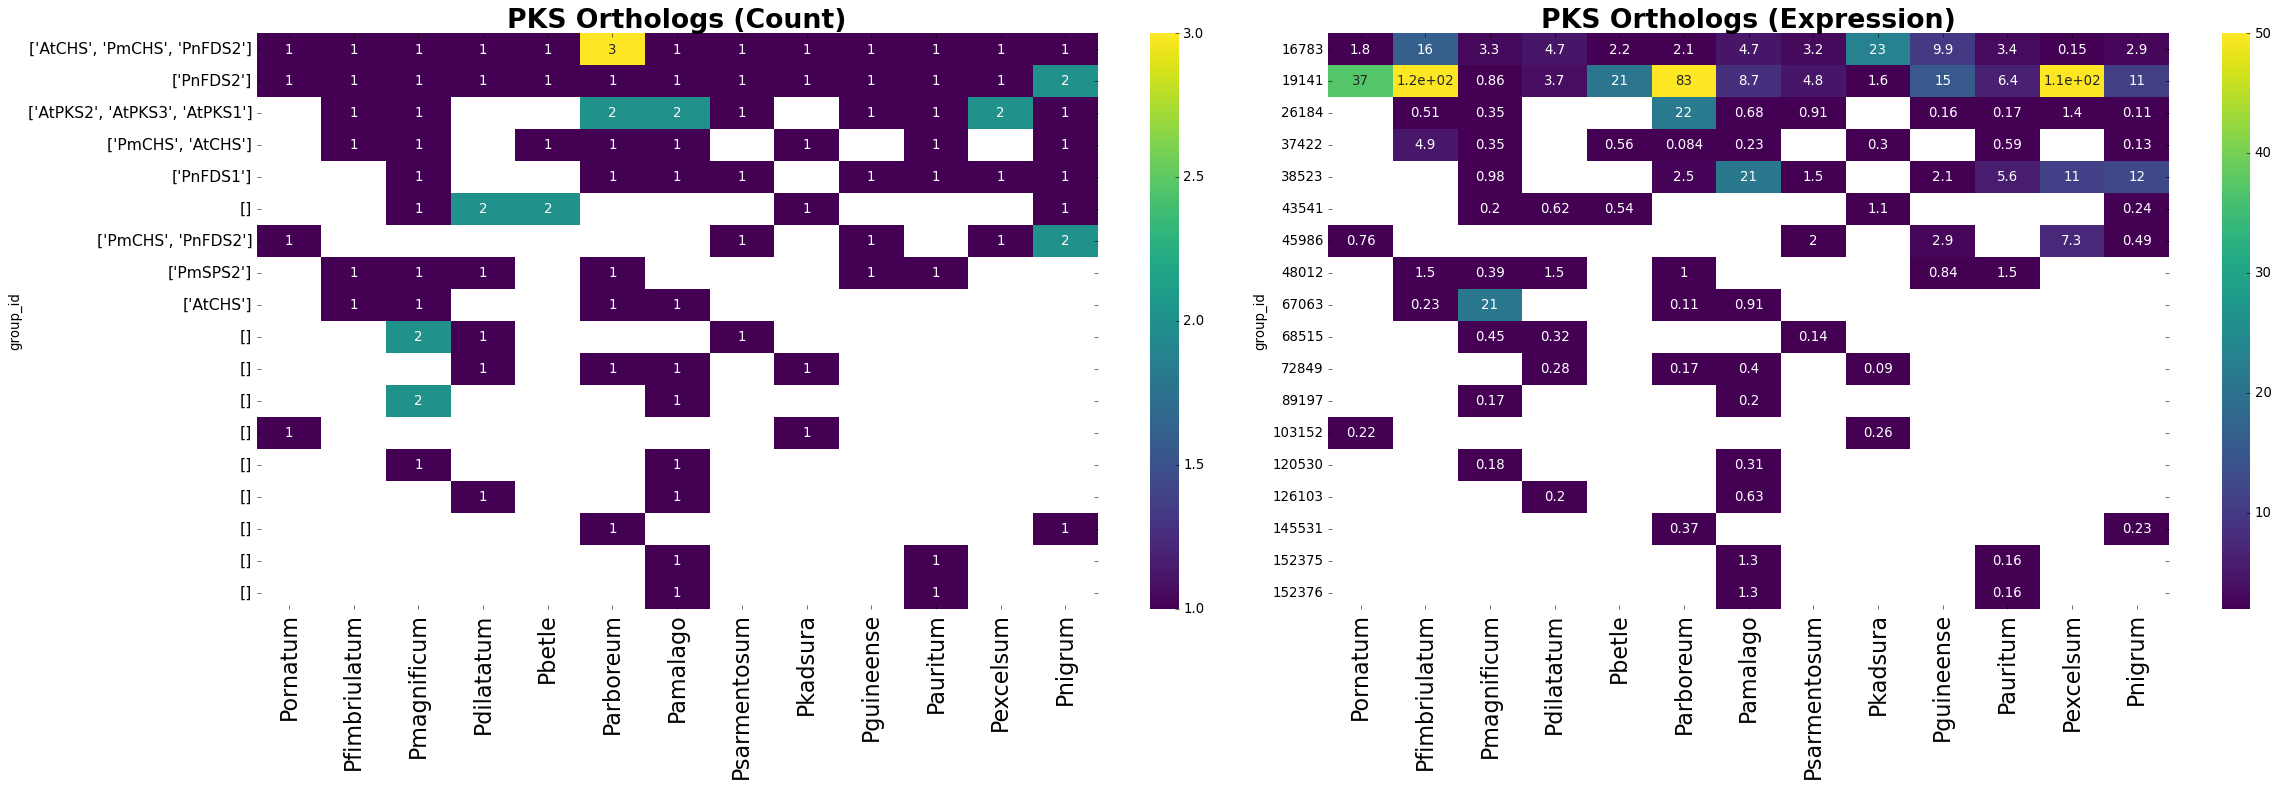

In [5]:
### Count-based heatmap
sample_cols = [col for col in sonicpd.columns if 'piper' in col] #keep piper columns

#keep PKS-related orthogroups
mask = sonicpd[sample_cols].applymap(lambda lst: any(elem in pks.index for elem in lst)).any(axis=1) 
pks_orths = sonicpd[mask]

#count orthologs per sample
pks_orths_count= pks_orths[sample_cols].applymap(len) 
pks_orths_count = pks_orths_count.rename(columns=species_names) #use species names
pks_orths_count = pks_orths_count.replace(0, np.nan) #replace 0 with NaN
print(f'Total N° of PKS candidates in orthologs: {pks_orths_count.sum().sum().astype(int)}')

### Expression-based heatmap
tpm = proteomes_all.loc[:, [col for col in proteome.columns if 'rep' in col]] #keep TPM columns

#function to assign expression value to orthogroup_table (max or mean TPM)
def assign_orth_expr(orthologs, metric='max'):
    '''
    Assign expression value to each entry in the orthogroup table. Expression values are retrieved from proteomes_all dataframe (max or mean TPM of individual genes)
    '''
    if metric == 'max':
        expr = tpm.loc[orthologs].max().max()
    elif metric == 'mean':
        expr = tpm.loc[orthologs].mean().mean()
    else:
        raise ValueError("Invalid metric. Expected 'max' or 'mean'.")
    return expr

pks_orths_expr = pks_orths[sample_cols].applymap(lambda x: assign_orth_expr(x, 'mean'))#.fillna(0) #apply funct to each entry in pks_orths
pks_orths_expr = pks_orths_expr.rename(columns=species_names) #use species names


### Assign annotation to orthogruops based on blast hits
blast_hits = pd.read_csv('results/blast/pks_hits.csv') #retrieve PKS BLAST results
top_hits = blast_hits.groupby('hit', as_index=False).apply(lambda x: x.sort_values('similarity', ascending=False).head(1)).reset_index(drop=True) #keep only top hit per query per sample

def assign_orth_annotation(orthologs):
    annotation = top_hits[top_hits['hit'].isin(orthologs)]
    return annotation['query'].values

orths_annot = pks_orths[sample_cols].applymap(lambda x: assign_orth_annotation(x))
orths_annot = orths_annot.apply(lambda row: list(set(itertools.chain(*row))), axis=1)


### Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

#count-based heatmap
sns.heatmap(pks_orths_count, annot=True, cmap='viridis', ax=axes[0])
axes[0].set_title('PKS Orthologs (Count)', fontdict={'fontsize': 24, 'fontweight': 'bold'})
axes[0].tick_params(axis='x', labelsize=20)  # Increase x-axis label size
axes[0].set_yticklabels(orths_annot.tolist(), fontsize=14) # Increase y-axis label size (orthologs names

#expr-based heatmap
sns.heatmap(pks_orths_expr, annot=True, cmap='viridis', vmin=2, vmax=50, ax=axes[1])
axes[1].set_title('PKS Orthologs (Expression)', fontdict={'fontsize': 24, 'fontweight': 'bold'})
axes[1].tick_params(axis='x', labelsize=20)  # Increase x-axis label size

#display plots
plt.tight_layout()
plt.show()

Total N°of PKS in orthogroups W/O Pfam domain: 5


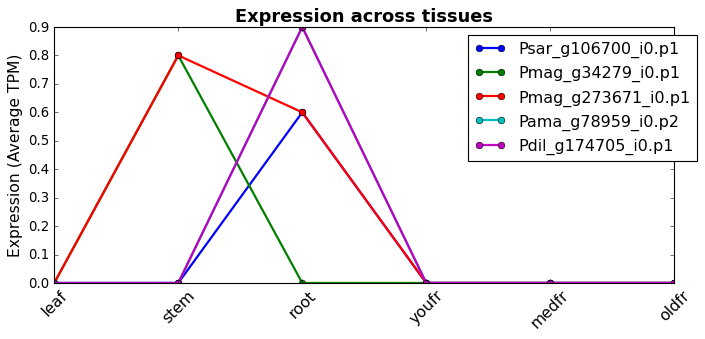

In [124]:
### PKS candidates in orthogroups W/O Pfam domain

#list of all PKS in orthogroups
pks_orths_list = []
for sample in pks_orths[sample_cols].columns: #iterate through each cell in pks_orths
    for genes_list in pks_orths[sample]:
        pks_orths_list.extend(genes_list)

#pks in orthogroups that are NOT in pks.index
pks_wo_pfam = list(set(pks_orths_list) - set(pks.index))
pks_wo_pfam = proteomes_all.loc[pks_wo_pfam]
print(f'Total N°of PKS in orthogroups W/O Pfam domain: {pks_wo_pfam.shape[0]}')

#plot expression values
tpm_cols = [col for col in proteomes_all.columns if 'rep' in col]

def average_tissue_expr(tpm_data, tissue_order=['leaf', 'stem', 'root', 'youfr', 'medfr', 'oldfr']):
    tissue_names = tpm_data.columns.str.split('_').str[0] #extract tissues from column names
    df_avg = tpm_data.groupby(by=tissue_names, axis=1).mean().round(1) #group df by tissue and calculate the mean for each tissue
    df_avg = df_avg[tissue_order] #reorder columns
    df_avg.fillna(0, inplace=True) #replace NaN with 0
    return df_avg

data = average_tissue_expr(pks_wo_pfam[tpm_cols])#.transpose()

# #labels for legend
# labels = [f'{label}_len{proteomes_all.loc[label, "length"]}_cov{proteomes_all.loc[label, "transcript_coverage"].round(1)}' for label in data.index]

def plot_expression(data, size=(10, 4)):
    
    plt.figure(figsize=size)


    # Plot the expression of each gene across tissues
    for index, row in data.iterrows():
        plt.plot(data.columns, row.values, label=index, linewidth=2, marker='o')
    
    #add title
    plt.title('Expression across tissues', fontsize=16, fontweight='bold')
    plt.ylabel('Expression (Average TPM)', fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best')
    plt.show()

plot_expression(data)

PKS (Pfam) NOT orthologs table: 60


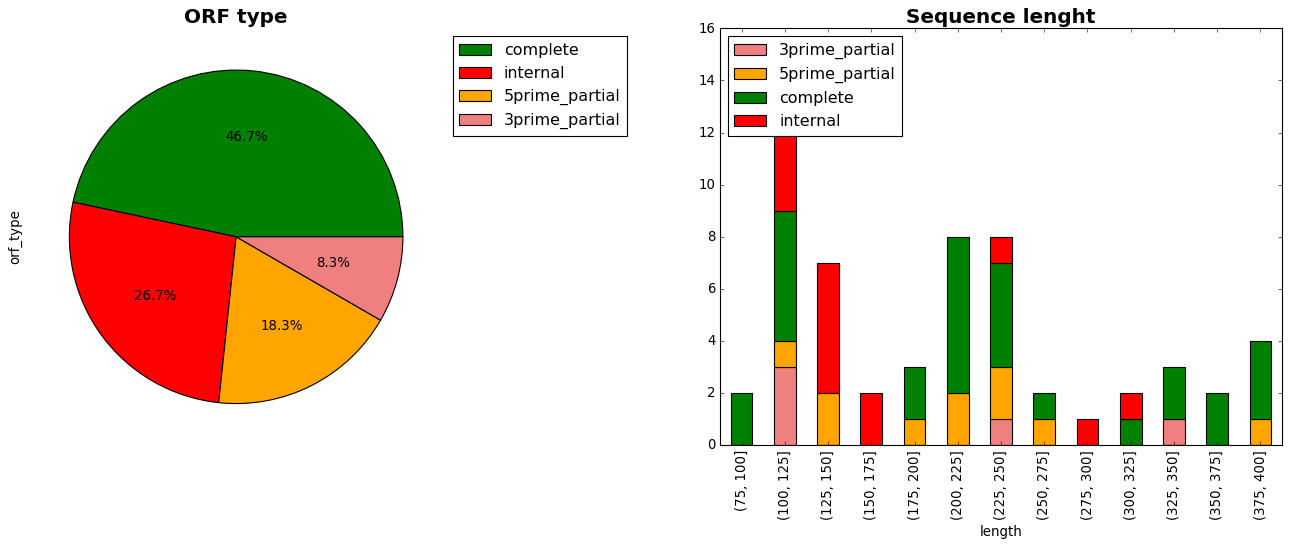

In [181]:
### PKS candidates not in orthogroups
unique_pks = list(set(pks.index) - set(pks_orths_list))
unique_pks = proteomes_all.loc[unique_pks]
unique_pks.shape
print(f'PKS (Pfam) NOT orthologs table: {unique_pks.shape[0]}')


fig, axs = plt.subplots(1, 2, figsize=(17, 7))

#orf_type distribution
pks_orftype = unique_pks['orf_type'].value_counts() #count orf_type

#map colors to orf_type
colormap = {'complete': 'green', '3prime_partial': 'lightcoral', '5prime_partial': 'orange', 'internal': 'red'}
colors = pks_orftype.index.map(lambda x: colormap[x])

#pie chart
pks_orftype.plot(kind='pie', autopct='%1.1f%%', colors=colors, legend=False, labels=None, ax=axs[0])
axs[0].set_title('ORF type', fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[0].legend(pks_orftype.index, bbox_to_anchor=(1, 1), loc='upper left') #legend

#sequence length distribution
bins = pd.cut(unique_pks['length'], bins=range(0, unique_pks['length'].max(), 25)) #bin pks['length']
count = unique_pks.groupby([bins, 'orf_type']).size().unstack() #count occurrence of orf_types in each bin
count = count[count.sum(axis=1) > 0] #drop all-zeros rows

#stacked bar plot
colors = count.columns.map(lambda x: colormap[x])
count.plot(kind='bar', stacked=True, color=colors, ax=axs[1])
axs[1].set_title('Sequence lenght', fontdict={'fontsize': 18, 'fontweight': 'bold'})
axs[1].legend(title=None, loc='upper left')  # remove legend title

#plot settings
plt.tight_layout()
plt.show()

Total N° of unique PKS: 60


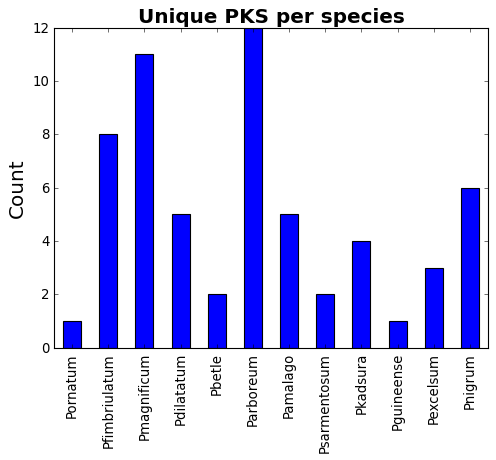

In [207]:
unique_pks_count = unique_pks.groupby('sample').size()
unique_pks_count.rename(index=species_names, inplace=True) #rename using species_names
print(f'Total N° of unique PKS: {unique_pks_count.sum()}')

#bar plot
plt.figure(figsize=(7,5))
unique_pks_count.plot(kind='bar')
plt.title('Unique PKS per species', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.xlabel('')
plt.ylabel('Count', fontdict={'fontsize': 18})
plt.show()

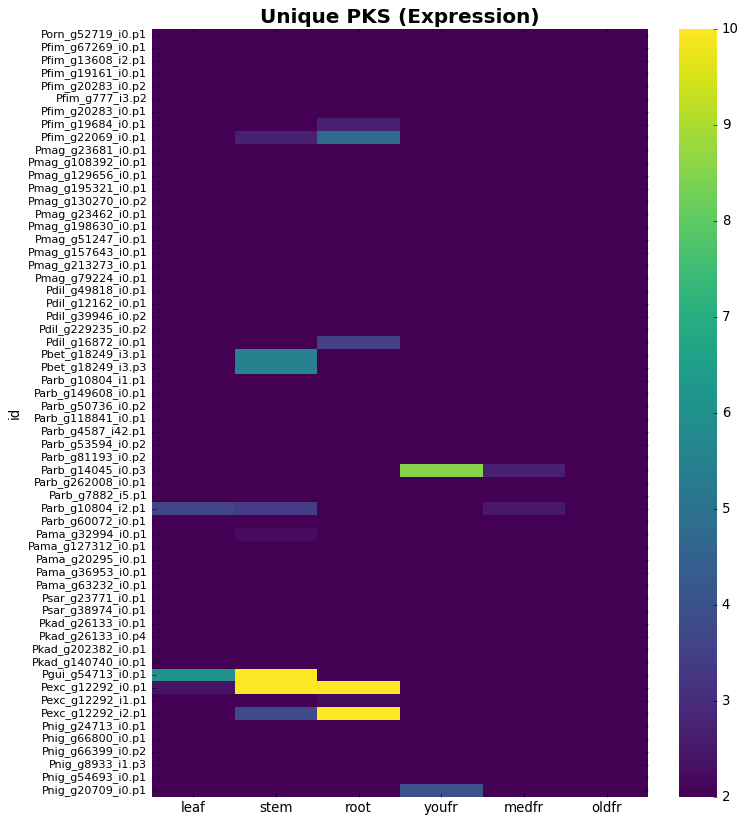

In [245]:
#heatmap of unique_pks_tpm
unique_pks_tpm = unique_pks.sort_values('sample').loc[:, [col for col in proteome.columns if 'rep' in col]] #keep TPM columns
data = average_tissue_expr(unique_pks_tpm)

plt.figure(figsize=(10, 12))
sns.heatmap(data, cmap='viridis', annot=False, yticklabels=True, vmin=2, vmax=10)
plt.yticks(fontsize=10)
plt.title('Unique PKS (Expression)', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.show()

### Phylogenetic tree of PKS candidates
Sequences aligned using MAFFT (locally) and phylogenetic tree builit using iqtree2 (on Aurum)

In [4]:
#write PKS sequences to fasta file
input_file = Path('results/phylogenetic_trees/pks/pks_pfam.fasta')

def write_fasta(df, filename):
    with open(filename, 'w') as f:
        for header, sequence in zip(df.index, df['sequence']):
            f.write(f'>{header}\n{sequence}\n')

write_fasta(pks, input_file)


#multiple sequence alignment (MAFFT)
output_file = input_file.with_name('pks_pfam_msa.fasta')

if not os.path.isfile(output_file):
    !mafft --auto {input_file} > {output_file}
else:
    print(f"File {output_file} already exists.")


#Create iTOL annotation file ###
legend = {prefixes[key]: legend[key] for key in legend if key in prefixes} #rename legend keys with prefixes

#create df with itol annotation
itol_map = {'id': pks.index,
        'range': 'range',
        'color': pks.index.to_series().apply(lambda x:  '#' + next((legend[k] for k in legend if x.startswith(k)), '')),
        'sample': pks['sample'],
        'species': 'species'}

itol_map = pd.DataFrame(itol_map).reset_index(drop=True)

#write file 
filepath = Path('results/phylogenetic_trees/pks/pks_pfam_itol.txt')

with open(filepath, 'w') as f:
    
    #write headers
    f.write('TREE_COLORS\n')
    f.write('SEPARATOR TAB\n')
    f.write('DATA\n')

    #append df with tab-separated format
    itol_map.to_csv(f, sep='\t', index=False, header=False)

File results/phylogenetic_trees/pks/pks_pfam_msa.fasta already exists.


# Heatmap with varying cell size - Test

/var/folders/fg/6v3nzv110nxg13st7w34pqvr0000gn/T/ipykernel_10052/3999193707.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=90)  # Rotate x ax


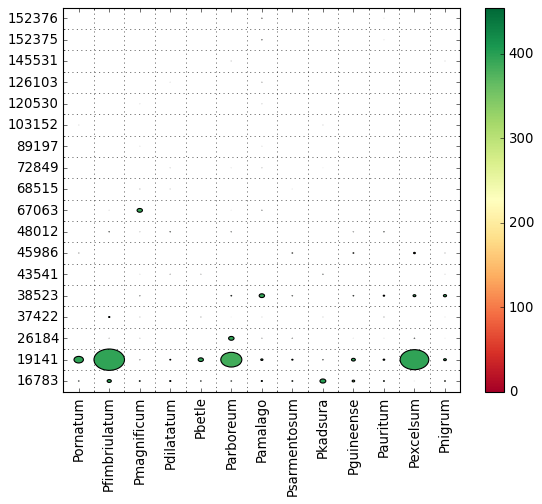

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection


N = pks_orths_expr.shape[0]
M = pks_orths_expr.shape[1]
data = data = pks_orths_expr.fillna(0).to_numpy()
c = pks_orths_lenght.to_numpy()

ylabels = pks_orths_expr.index
xlabels = pks_orths_expr.columns

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = data
# c = np.random.rand(N, M)-0.5

fig, ax = plt.subplots()

R = s/s.max()/2
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="RdYlGn")
ax.add_collection(col)


# Here's where we specify the rotation for the x-axis labels
ax.set_xticklabels(xlabels, rotation=90)  # Rotate x ax

ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

fig.colorbar(col)
plt.show()

In [51]:
c


,piper06,piper09,piper10,piper12,piper20,piper23,piper25,piper26,piper27,piper32,piper54,piper55,piper56
group_id,,,,,,,,,,,,,
16783,401.0,396.0,401.0,401.0,401.0,396.0,401.0,404.0,401.0,348.0,401.0,302.0,319.0
19141,395.0,395.0,395.0,395.0,395.0,385.0,395.0,395.0,395.0,395.0,395.0,395.0,395.0
26184,0.0,323.0,391.0,0.0,0.0,396.0,244.0,323.0,0.0,152.0,184.0,455.0,225.0
37422,0.0,399.0,184.0,0.0,297.0,301.0,252.0,0.0,223.0,0.0,153.0,0.0,339.0
38523,0.0,0.0,418.0,0.0,0.0,430.0,394.0,399.0,0.0,399.0,425.0,399.0,401.0
43541,0.0,0.0,303.0,113.0,149.0,0.0,0.0,0.0,444.0,0.0,0.0,0.0,441.0
45986,201.0,0.0,0.0,0.0,0.0,0.0,0.0,197.0,0.0,201.0,0.0,188.0,367.0
48012,0.0,395.0,395.0,395.0,0.0,395.0,0.0,0.0,0.0,398.0,395.0,0.0,0.0
67063,0.0,389.0,391.0,0.0,0.0,391.0,417.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
### Expression-based heatmap
tpm = proteomes_all.loc[:, [col for col in proteome.columns if 'rep' in col]].fillna(0).round(1) #TPM data
lengths = proteomes_all.loc[:, 'length'] #sequence lenghts

pks_orths[sample_cols]

,piper06,piper09,piper10,piper12,piper20,piper23,piper25,piper26,piper27,piper32,piper54,piper55,piper56
group_id,,,,,,,,,,,,,
16783,[Porn_g23680_i0.p1],[Pfim_g9212_i1.p1],[Pmag_g37537_i0.p1],[Pdil_g13033_i1.p1],[Pbet_g16475_i0.p1],"[Parb_g12475_i1.p1, Parb_g32725_i0.p1, Parb_g3...",[Pama_g17209_i1.p1],[Psar_g184_i58.p1],[Pkad_g18571_i0.p1],[Pgui_g17154_i0.p1],[Paur_g11503_i1.p1],[Pexc_g25292_i0.p1],[Pnig_g16384_i0.p1]
19141,[Porn_g15459_i1.p1],[Pfim_g13608_i1.p1],[Pmag_g27854_i0.p1],[Pdil_g16718_i2.p1],[Pbet_g18249_i2.p1],[Parb_g14045_i2.p1],[Pama_g24981_i1.p1],[Psar_g25232_i0.p1],[Pkad_g23510_i0.p1],[Pgui_g15351_i1.p1],[Paur_g16197_i1.p1],[Pexc_g12730_i1.p1],"[Pnig_g909_i25.p1, Pnig_g8672_i1.p1]"
26184,[],[Pfim_g17426_i0.p1],[Pmag_g11660_i0.p1],[],[],"[Parb_g16041_i2.p1, Parb_g16041_i4.p1]","[Pama_g59677_i0.p1, Pama_g62379_i0.p1]",[Psar_g9900_i0.p2],[],[Pgui_g112978_i0.p1],[Paur_g49590_i0.p1],"[Pexc_g3772_i3.p1, Pexc_g3772_i0.p2]",[Pnig_g44643_i0.p1]
37422,[],[Pfim_g17829_i0.p1],[Pmag_g97282_i0.p1],[],[Pbet_g36332_i0.p1],[Parb_g18005_i2.p1],[Pama_g62182_i0.p1],[],[Pkad_g72996_i0.p1],[],[Paur_g60345_i0.p1],[],[Pnig_g34333_i0.p1]
38523,[],[],[Pmag_g1428_i4.p1],[],[],[Parb_g24578_i0.p1],[Pama_g20295_i1.p1],[Psar_g28415_i1.p1],[],[Pgui_g21625_i0.p1],[Paur_g19181_i0.p1],[Pexc_g14782_i0.p1],[Pnig_g8933_i0.p1]
43541,[],[],[Pmag_g51384_i0.p1],"[Pdil_g213442_i0.p2, Pdil_g213796_i0.p1]","[Pbet_g82752_i0.p1, Pbet_g100323_i0.p1]",[],[],[],[Pkad_g29054_i0.p1],[],[],[],[Pnig_g25150_i0.p1]
45986,[Porn_g15459_i0.p1],[],[],[],[],[],[],[Psar_g25232_i2.p1],[],[Pgui_g15351_i0.p1],[],[Pexc_g12730_i0.p2],"[Pnig_g909_i20.p1, Pnig_g909_i22.p1]"
48012,[],[Pfim_g20510_i0.p1],[Pmag_g31471_i0.p1],[Pdil_g17712_i1.p1],[],[Parb_g7882_i12.p1],[],[],[],[Pgui_g30094_i0.p1],[Paur_g17997_i0.p1],[],[]
67063,[],[Pfim_g19753_i0.p1],[Pmag_g28393_i0.p1],[],[],[Parb_g30367_i0.p1],[Pama_g34420_i0.p1],[],[],[],[],[],[]


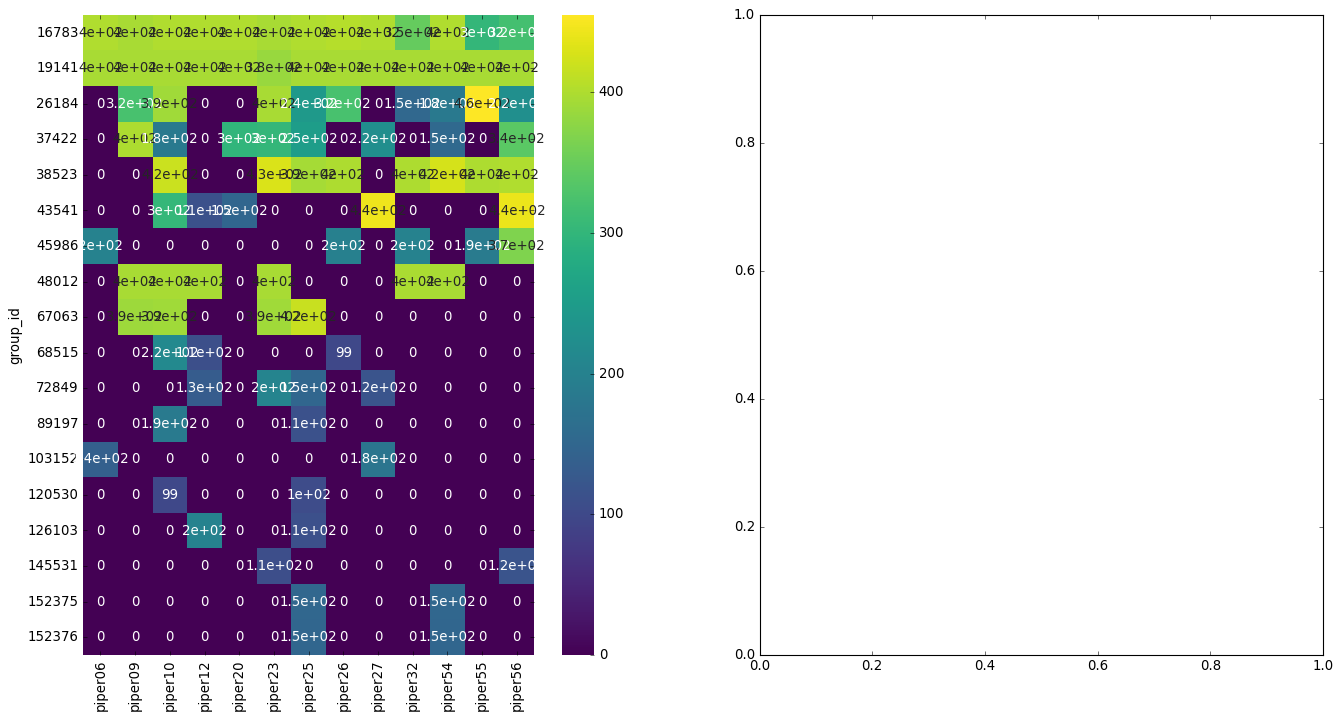

In [47]:
#keep PKS-related orthogroups
mask = sonicpd[sample_cols].applymap(lambda lst: any(elem in pks.index for elem in lst)).any(axis=1) 
pks_orths = sonicpd[mask]
pks_orths

#function to assign expression value to orthogroup_table (max or mean TPM)
def assign_top_len(orthologs, metric='max'):
    '''
    Assign expression value to each entry in the orthogroup table. Expression values are retrieved from proteomes_all dataframe (max or mean TPM of individual genes)
    '''
    if metric == 'max':
        length = lengths.loc[orthologs].max()
    elif metric == 'mean':
        length = lengths.loc[orthologs].mean()
    else:
        raise ValueError("Invalid metric. Expected 'max' or 'mean'.")
    return length


pks_orths_lenght = pks_orths[sample_cols].applymap(lambda x: assign_top_len(x, 'max'))
pks_orths_lenght.fillna(0, inplace=True)
pks_orths_lenght

#create one figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(pks_orths_lenght, annot=True, cmap='viridis', ax=axes[0])
plt.show()
